Write some code to remove lens distortion from an image.

In [114]:
# from warping import *
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

The custom functions in package `warping` is not provided. So I used Claude to generate these three helper functions that can do the same job.

In [115]:
def griddify(shape, n, m):
    """
    Generates a 2D grid of coordinates for an image based on its dimensions.

    Args:
        shape (tuple): A tuple representing the height and width of the image, typically in the form (height, width).
        n (int): The number of points along the x-axis (horizontal direction).
        m (int): The number of points along the y-axis (vertical direction).

    Returns:
        numpy.ndarray: A 3D array of shape (m+1, n+1, 2), where each element represents a point in the grid. The last dimension contains
        the x and y coordinates for each point in the form (x, y).
        
    Description:
        This function uses `numpy.linspace` to create evenly spaced points along the x-axis and y-axis of the image, forming a grid of coordinates.
        The `grid_x` and `grid_y` arrays represent the positions of these points on the x and y axes, respectively.
        These arrays are then stacked to form a 3D array where each element contains a pair of coordinates representing the position of each point in the grid.
        
        The grid can then be used as a reference for warping or applying transformations to the image.
    """
    x = np.linspace(0, shape[1], n + 1)  # Generate n+1 points along x-axis
    y = np.linspace(0, shape[0], m + 1)  # Generate n+1 points along y-axis
    grid_x, grid_y = np.meshgrid(x, y)
    return np.stack((grid_x, grid_y), axis=-1)

In [116]:
def shape_to_rect(shape):
    """
    Converts the dimensions of an image into a rectangle format.

    Args:
        shape (tuple): A tuple representing the height and width of the image, typically in the form (height, width).

    Returns:
        tuple: A tuple in the form (height, width), representing the dimensions of the image.
        
    Description:
        This simple function takes the image dimensions (height and width) and returns them in the same form, allowing
        it to be used in other functions that expect these dimensions as input.
    """
    return (shape[0], shape[1])

In [117]:
def grid_to_mesh(src, dst):
    """
    Creates a mesh for image warping by mapping source and destination grid coordinates.

    Args:
        src (numpy.ndarray): A 3D array of shape (m+1, n+1, 2), containing the source grid coordinates (x, y) for each point.
        dst (numpy.ndarray): A 3D array of shape (m+1, n+1, 2), containing the destination grid coordinates (x, y) for each point.
        width (int): The width of the image.
        height (int): The height of the image.

    Returns:
        list: A list of tuples where each tuple contains:
              - box: A tuple representing the bounding box in the destination grid, in the form (x1, y1, x2, y2).
              - quad: A list of four tuples, each containing the source coordinates of the quadrilateral that maps to the corresponding box.
              
    Description:
        This function constructs a mesh of quadrilateral patches by dividing the image grid into smaller rectangular regions (boxes) in the destination
        grid and mapping them to corresponding quadrilateral regions in the source grid.
        
        Each `box` in the destination grid is a rectangle defined by the top-left (x1, y1) and bottom-right (x2, y2) coordinates.
        Each `quad` in the source grid contains the four corner points that map to the `box`. These points represent the transformed positions in the
        source image that map to the destination image.

        The function ensures that all coordinates are clipped within the image dimensions to avoid out-of-bound errors during warping.
        The mesh produced by this function is used by the `PIL.Image.transform` method to apply the warping transformation to the image.
    """
    mesh = []
    rows, cols = src.shape[:2]
    for i in range(rows - 1):
        for j in range(cols - 1):
            # Define the destination rectangle
            rect = (
                dst[i, j, 0],
                dst[i, j, 1],
                dst[i + 1, j + 1, 0],
                dst[i + 1, j + 1, 1],
            )

            # Define the corresponding source quadrilateral
            quad = (
                src[i, j, 0],
                src[i, j, 1],
                src[i + 1, j, 0],
                src[i + 1, j, 1],
                src[i + 1, j + 1, 0],
                src[i + 1, j + 1, 1],
                src[i, j + 1, 0],
                src[i, j + 1, 1],
            )

            mesh.append((rect, quad))

    return mesh

In [118]:
# load square, grayscale image
im = Image.open('assets/HanyFaridDistort.jpg')
[ydim,xdim] = im.size
mid=round(max(xdim,ydim)/2)

The reason we need `mid` is because we need to find the distance of every pixel relative to the center of the image.

In [119]:
# define sampling lattices
n = 100 # latice sampling
dst = griddify(shape_to_rect(im.size), n, n) # destination grid
src = dst # source grid

Define the distored coordinates with the equations mentioned in lecture.

In [120]:
# define new sampling lattice (src)
k = 0.0000005 # estimated lens distortion
dst = dst - mid # put image center at (0,0)
for i in range(n+1):
    for j in range(n+1):
        x = dst[i,j,0]
        y = dst[i,j,1]
        r = np.sqrt(x**2 + y**2)
        src[i,j,0] = x * (1 + k*r**2)
        src[i,j,1] = y * (1 + k*r**2)


In [121]:
dst = dst + mid # re-center
dst = dst.astype(int)  # convert to integer
src = src + mid # re-center
src = src.astype(int)  # convert to integer

Move the distorted pixels back to undistorted positions.

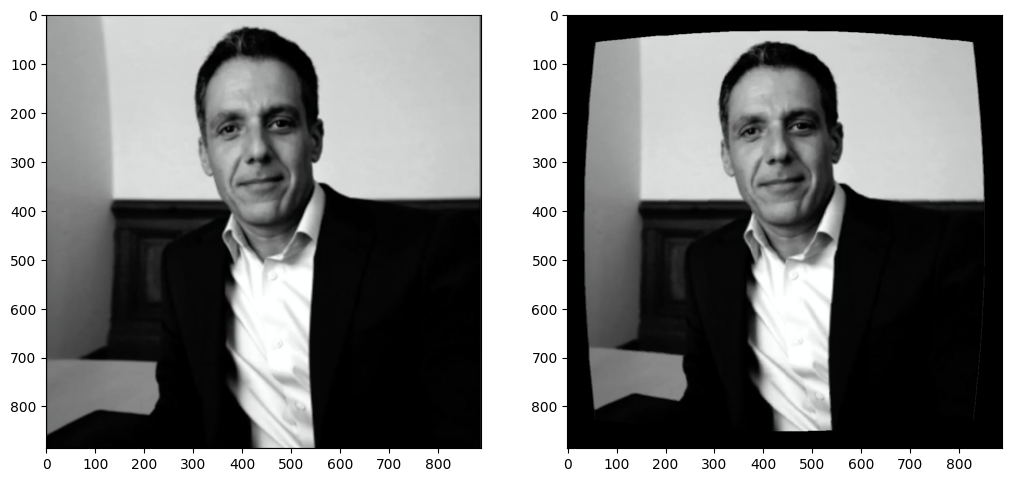

In [122]:
# warp image
mesh = grid_to_mesh(src, dst) # define mesh
imt = im.transform(im.size, Image.MESH, mesh) # warp
plt.figure(figsize=(ydim/72,xdim/72))
plt.subplot(1,2,1)
plt.imshow(im,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imt,cmap='gray')
plt.show()